# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

In [56]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import cv2
import os
from imutils import paths
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from google.colab import drive
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет. 

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [57]:
drive.mount('/content/gdrive/', force_remount=True)
df = pd.read_csv('gdrive/MyDrive/persons_pics_train/persons_pics_train.csv')

Mounted at /content/gdrive/


In [46]:
df

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,0.237908,0.273203,0.244444,0.332026,0.590850,0.675817,0.684967,0.733333,0.771242,0.771242,...,0.686275,0.694118,0.720261,0.746405,0.756863,0.735948,0.715033,0.684967,0.657516,Tony Blair
1322,0.105882,0.087582,0.117647,0.260131,0.385621,0.466667,0.566013,0.657516,0.692810,0.691503,...,0.722876,0.376471,0.188235,0.139869,0.188235,0.226144,0.243137,0.248366,0.244444,Gerhard Schroeder
1323,0.322876,0.345098,0.369935,0.375163,0.405229,0.464052,0.494118,0.511111,0.517647,0.495425,...,0.465359,0.486274,0.505882,0.535948,0.550327,0.551634,0.552941,0.554248,0.563399,George W Bush
1324,0.304575,0.290196,0.366013,0.444444,0.456209,0.465359,0.479739,0.532026,0.585621,0.603922,...,0.513725,0.802614,0.942484,0.933333,0.707190,0.223529,0.124183,0.133333,0.113725,George W Bush


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [58]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

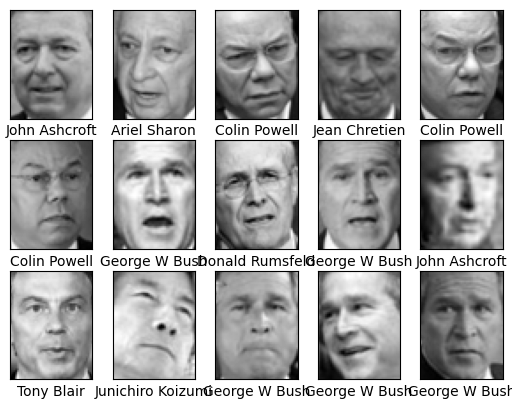

In [59]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl)
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')    

Крупнее

(-0.5, 46.5, 61.5, -0.5)

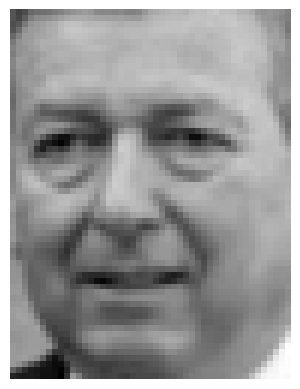

In [60]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [63]:
df['label'].value_counts()

George W Bush        451
Colin Powell         201
Tony Blair           122
Donald Rumsfeld      103
Gerhard Schroeder     93
Ariel Sharon          65
Hugo Chavez           60
Junichiro Koizumi     51
Jean Chretien         47
John Ashcroft         45
Serena Williams       44
Jacques Chirac        44
Name: label, dtype: int64

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса. 

In [62]:
df[df['label']=='Gerhard Schroeder']['label'].value_counts().sum()/df['label'].value_counts().sum()

0.07013574660633484

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [8]:
df[df['label']=='Junichiro Koizumi']['0'].mean()

0.26838396082352944

In [9]:
df['label'].value_counts()

George W Bush        451
Colin Powell         201
Tony Blair           122
Donald Rumsfeld      103
Gerhard Schroeder     93
Ariel Sharon          65
Hugo Chavez           60
Junichiro Koizumi     51
Jean Chretien         47
John Ashcroft         45
Serena Williams       44
Jacques Chirac        44
Name: label, dtype: int64

Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [10]:
df[df['label']=='Jacques Chirac']['label'].value_counts().sum()/df['label'].value_counts().sum()

0.033182503770739065

Используя усредненные векторы, постройте изображения всех людей из набора данных.

In [49]:
col = df.columns[:-1]
col

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '2904', '2905', '2906', '2907', '2908', '2909', '2910', '2911', '2912',
       '2913'],
      dtype='object', length=2914)

In [12]:
df_face = df.groupby(['label']).mean(list(col))
df_label =df_face.index

In [42]:
df_label

Index(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac', 'Jean Chretien',
       'John Ashcroft', 'Junichiro Koizumi', 'Serena Williams', 'Tony Blair'],
      dtype='object', name='label')

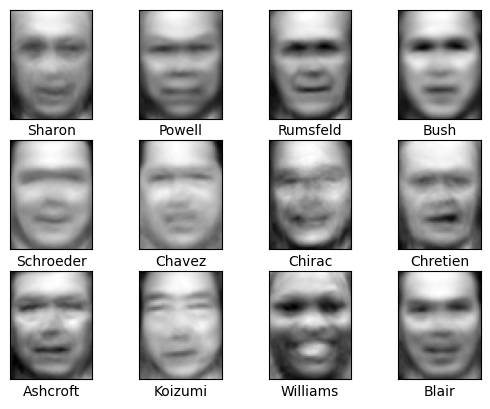

In [64]:

fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img = (df_face.iloc[i])[col].to_numpy().reshape(62,47)
    lbl = df_label[i]
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')    

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [65]:
Donald_Rumsfeld=(df_face.iloc[1])[col].to_numpy()

In [66]:
Serena_Williams=(df_face.iloc[4])[col].to_numpy()

In [67]:

object_vectors = [
    (df_face.iloc[1])[col].to_numpy(),
    (df_face.iloc[4])[col].to_numpy()
]

object_matrix = np.vstack(object_vectors)
cosine_similarity(object_matrix)


array([[1.        , 0.99546998],
       [0.99546998, 1.        ]])

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [ ]:
# < ENTER YOUR CODE HERE > 

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [71]:
X = df.drop('label',axis=1)
Y = df['label']
x,xt,y,yt =train_test_split(X,Y,test_size=0.2, random_state=11,stratify=Y)
model = SVC(kernel='linear', random_state=5).fit(x,y)

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [72]:
pred= model.predict(xt)

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [73]:
f1_score(yt,pred,average='weighted')

0.7838258158689967

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [20]:
from sklearn.model_selection import GridSearchCV

In [74]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[11]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3).fit(x,y)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.807 total time=   2.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.792 total time=   2.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.769 total time=   1.9s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.797 total time=   1.7s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.764 total time=   1.3s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.349 total time=   1.7s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.358 total time=   1.6s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.368 total time=   1.6s
[CV 4/5] END C=1, class_weight=N

Определите гиперпараметры лучшей полученной модели.

In [75]:
cv.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 11}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [76]:
pred1 = SVC(C=100,class_weight='balanced',gamma=0.001,kernel ='rbf', random_state=9).fit(x,y).predict(xt)
f1_score(yt,pred1,average='weighted')

0.8104755950985177

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [77]:
pca =PCA(svd_solver='full').fit(x)
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)
n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f"Минимальное количество компонент для уровня объясненной дисперсии > 0.95: {n_components}")

Минимальное количество компонент для уровня объясненной дисперсии > 0.95: 172


Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [78]:
col_to =col[:172]

In [79]:
pca = PCA(n_components=172, svd_solver='full').fit(x)
x[col_to] = pca.transform(x)
xt[col_to] = pca.transform(xt)

In [80]:
col

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '2904', '2905', '2906', '2907', '2908', '2909', '2910', '2911', '2912',
       '2913'],
      dtype='object', length=2914)

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [81]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[11]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3).fit(x,y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.778 total time=   1.7s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.783 total time=   1.7s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.759 total time=   1.7s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.792 total time=   1.3s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.750 total time=   2.0s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.401 total time=   6.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.410 total time=   3.2s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.458 total time=   1.8s
[CV 4/5] END C=1, class_weight=N

KeyboardInterrupt: ignored

Определите гиперпараметры лучшей полученной модели.

In [30]:
cv.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 9}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [82]:
pred1 = SVC(C=100,class_weight='balanced',gamma=0.001,kernel ='rbf', random_state=9).fit(x,y).predict(xt)
f1_score(yt,pred1,average='weighted')

0.801884599073343

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.

In [33]:
pred1 = SVC(C=100,class_weight='balanced',gamma=0.001,kernel ='rbf', random_state=9).fit(x,y).predict(xt)
f1_score(yt,pred1,average='weighted')

0.7860567952946039

In [52]:
pred1

array(['Tony Blair', 'Gerhard Schroeder', 'Gerhard Schroeder',
       'Colin Powell', 'Tony Blair', 'Jean Chretien', 'George W Bush',
       'George W Bush', 'Tony Blair', 'George W Bush', 'Tony Blair',
       'George W Bush', 'Donald Rumsfeld', 'George W Bush',
       'George W Bush', 'Tony Blair', 'Colin Powell', 'Gerhard Schroeder',
       'George W Bush', 'George W Bush', 'Colin Powell', 'Ariel Sharon',
       'George W Bush', 'George W Bush', 'Donald Rumsfeld',
       'Gerhard Schroeder', 'Colin Powell', 'Gerhard Schroeder',
       'Jean Chretien', 'Donald Rumsfeld', 'George W Bush',
       'Donald Rumsfeld', 'Donald Rumsfeld', 'Donald Rumsfeld',
       'George W Bush', 'Junichiro Koizumi', 'George W Bush',
       'John Ashcroft', 'George W Bush', 'Colin Powell', 'George W Bush',
       'George W Bush', 'Colin Powell', 'Colin Powell', 'George W Bush',
       'Gerhard Schroeder', 'George W Bush', 'George W Bush',
       'Donald Rumsfeld', 'Hugo Chavez', 'Tony Blair',
       'Gerhar

In [34]:
test = pd.read_csv('gdrive/MyDrive/persons_pics_reserved/persons_pics_reserved.csv')

In [37]:
test

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,0.315033,0.393464,0.517647,0.636601,0.652288,0.653595,0.677124,0.725490,0.716340,0.695425,...,0.031373,0.047059,0.047059,0.053595,0.050980,0.036601,0.027451,0.011765,0.007843,0.003922
1,0.518954,0.664052,0.690196,0.627451,0.576471,0.575163,0.605229,0.633987,0.666667,0.684967,...,0.568627,0.583007,0.577778,0.549020,0.479739,0.403922,0.427451,0.569935,0.772549,0.924183
2,0.196078,0.205229,0.219608,0.197386,0.179085,0.223529,0.295425,0.363399,0.411765,0.471895,...,0.471895,0.479739,0.486274,0.511111,0.528105,0.556863,0.586928,0.611765,0.610458,0.627451
3,0.330719,0.376471,0.413072,0.420915,0.430065,0.454902,0.477124,0.486274,0.487582,0.494118,...,0.688889,0.715033,0.724183,0.695425,0.308497,0.126797,0.125490,0.125490,0.111111,0.109804
4,0.405229,0.428758,0.487582,0.567320,0.619608,0.648366,0.665359,0.686275,0.701961,0.717647,...,0.611765,0.630065,0.627451,0.746405,0.700654,0.200000,0.099346,0.095425,0.087582,0.083660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.435294,0.490196,0.541176,0.601307,0.631373,0.647059,0.681046,0.692810,0.696732,0.720261,...,0.588235,0.586928,0.606536,0.600000,0.654902,0.769935,0.909804,0.986928,0.994771,0.990850
230,0.478431,0.558170,0.601307,0.618301,0.637908,0.649673,0.653595,0.640523,0.630065,0.615686,...,0.128105,0.064052,0.079739,0.091503,0.077124,0.077124,0.074510,0.074510,0.082353,0.086275
231,0.483660,0.474510,0.494118,0.512418,0.529412,0.555556,0.590850,0.626144,0.641830,0.662745,...,0.573856,0.624837,0.707190,0.811765,0.933333,0.985621,0.981699,0.985621,0.989542,0.983007
232,0.284967,0.453595,0.415686,0.384314,0.341176,0.354248,0.407843,0.397386,0.330719,0.324183,...,0.292810,0.301961,0.315033,0.301961,0.390850,0.639216,0.835294,0.904575,0.933333,0.938562


In [55]:
SVC(C=100,class_weight='balanced',gamma=0.001,kernel ='rbf', random_state=9).fit(X,Y).predict(test)

array(['George W Bush', 'Ariel Sharon', 'Tony Blair', 'Jacques Chirac',
       'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Colin Powell',
       'Tony Blair', 'Gerhard Schroeder', 'Donald Rumsfeld',
       'Hugo Chavez', 'George W Bush', 'Hugo Chavez', 'Colin Powell',
       'George W Bush', 'Ariel Sharon', 'Colin Powell', 'John Ashcroft',
       'Gerhard Schroeder', 'Ariel Sharon', 'Donald Rumsfeld',
       'Colin Powell', 'George W Bush', 'George W Bush',
       'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair',
       'Serena Williams', 'Jean Chretien', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'Colin Powell', 'Donald Rumsfeld', 'Jacques Chirac',
       'George W Bush', 'Gerhard Schroeder', 'Colin Powell',
       'Donald Rumsfeld', 'Gerhard Schroeder', 'George W Bush',
       'Tony Blair', 'George W Bush', 'George W Bush', 'Tony Blair',
       'Colin Powell', 'Tony Blair', 'Serena Williams', 'Jean Chretien',
       'Ton